A real analysis rarely deals with objects in isolation - just one electron or one jet. More common are combinations of objects. The `hep_tables` package does this by leaning primarily on the `map` function previously described and python's captured variables. Extending the data model also makes it much to work with the multi-object data.

In [1]:
from hep_tables import xaod_table, make_local, curry
from dataframe_expressions import user_func, define_alias
from func_adl import EventDataset
import matplotlib.pyplot as plt

import numpy as np

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Define DeltaR function availible on servicex (see the functions intro for more info)
@user_func
def DeltaR(p1_eta: float, p1_phi: float, p2_eta: float, p2_phi: float) -> float:
    '''
    Calculate the DeltaR between two particles given their `eta` and `phi` locations.
    Implemented on the back end.
    '''
    assert False, 'This should never be called'
    
define_alias('', 'ptgev', lambda o: o.pt / 1000.0)

import logging
logging.getLogger('urllib3.connectionpool').setLevel(logging.WARNING)

In [2]:
dataset = EventDataset('localds://mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00')
df = xaod_table(dataset)

## Matching two objects

For this example we are going to match a MC electron to a reconstructed electron.

First thing is to clean out input. We know from previous sections of this notebook that we want central electrons with $p_T>25$ GeV. We'll do the same for truth particles (`abs(pdgId) == 11`).

We need to look at the MC particles, select the electrons, and then match them to electrons in the actual dataset. I've not done this in this dataset before, so I'm going to have to feel my way a bit with a few plots to allow me to understand what is going on.

First, lets get a plot of the MC electrons. I had to look up the pdg id (embarassing): `11` - Note that -11 isn't being used here because of a bug that this turned up in the backend (see [bug](https://github.com/iris-hep/func_adl_xAOD/issues/37))!

In [3]:
mc_part = df.TruthParticles('TruthParticles')
mc_ele = mc_part[(mc_part.pdgId == 11) | (mc_part.pdgId == -11)]

eles = df.Electrons('Electrons')

def good_e(e):
    'Good electron particle'
    return (e.ptgev > 20) & (abs(e.eta) < 1.4)

good_eles = eles[good_e]
good_mc_ele = mc_ele[good_e]

Lets plot the $p_T$ just to make sure we are being sane here

In [4]:
%%time
good_mc_ele_pt = make_local(good_mc_ele.ptgev)
good_eles_pt = make_local(good_eles.ptgev)



Wall time: 3.06 s


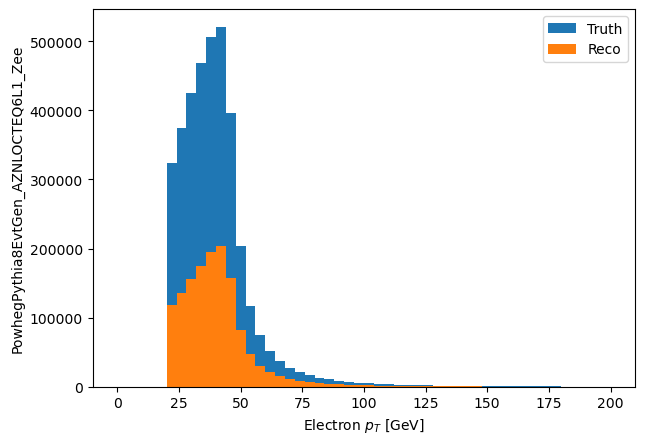

In [5]:
plt.hist(good_mc_ele_pt.flatten(), bins=50, range=(0,200), label='Truth')
plt.hist(good_eles_pt.flatten(), bins=50, range=(0,200), label='Reco')
plt.xlabel('Electron $p_T$ [GeV]')
plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')
plt.legend()

To do the assocation, the algorithm could be thought of as this:

- Look at each electron
- Look at all the MC electrons
- Find the one closest

This probably isn't the best algorithm, but it works most of the time. We will have to modify it mostly because the idea of _sorting_ isn't availible at this time in any of the backends we are currently using.

The approach we will take is to create a generic function that will add a few new "branches" to the electron data model:

- *hasMC* - there is at least one MC electron near by this reconstructed electron
- *MC* - A MC particle close by
- *all_MC* - all MC particles that are within 0.4.

In [6]:
def associate_particles(source, pick_from):
    '''
    Associate each particle from source with a close by one from the particle list pick_from. Extend source's data model.
    
    Args:
        source            The particles we want to start from
        pick_from         For each partcile from source, we'll find a close by one from pick_form.
        name              Naming we can use when we extend the data model.
        
    Returns:
        with_assoc        The source particles that had a close by match
    '''
    def dr(p1, p2):
        'short hand for calculating DR between two particles.'
        return DeltaR(p1.eta(), p1.phi(), p2.eta(), p2.phi())

    def very_near(picks, p):
        'Return all particles in picks that are DR less than 0.1 from p'
        return picks[lambda ps: dr(ps, p) < 0.1]

    source[f'all'] = lambda source_p: very_near(pick_from, source_p)
    
    source[f'has_match'] = lambda e: e.all.Count() > 0
    with_assoc = source[source.has_match]
    with_assoc['mc'] = lambda e: e.all.First()
    
    return with_assoc

matched = associate_particles(good_eles, good_mc_ele)

The most important line in the function above is this one:

```
    source[f'all'] = lambda source_p: very_near(pick_from, source_p)
```

This defines a new column `all` using the `lambda` computed column format. For each particle in `source`, the function `very_near(pick_from, source_p)` is computed (in a columnar way!). The `very_near` function looks at all the MC particles, and windows them by those that are within $\Delta R < 0.1$ - and returns that list.

Lets look at a few things. First, the $p_T$ of the matched and unmatched electrons.

In [7]:
matched_ele_pt = make_local(good_eles[good_eles.has_match].ptgev)
unmatched_ele_pt = make_local(good_eles[~good_eles.has_match].ptgev)

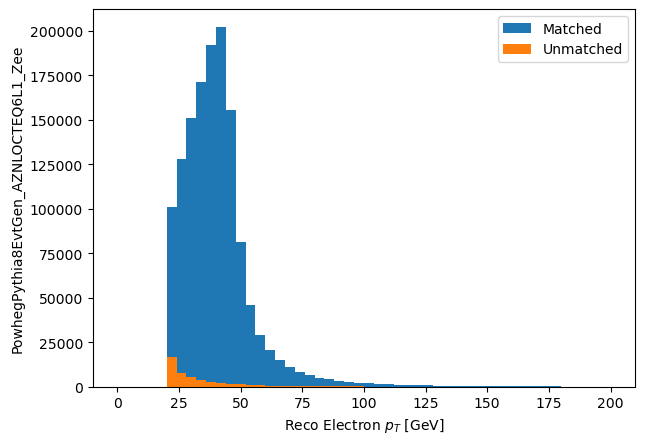

In [8]:
plt.hist(matched_ele_pt.flatten(), bins=50, range=(0,200), label='Matched')
plt.hist(unmatched_ele_pt.flatten(), bins=50, range=(0,200), label='Unmatched')
plt.xlabel('Reco Electron $p_T$ [GeV]')
plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')
plt.legend()

Lets compare the $p_T$ of matched electrons to their matched MC particle:

In [9]:
pt_matched_mc = make_local(matched.mc.ptgev)
pt_matched_reco = make_local(matched.ptgev)

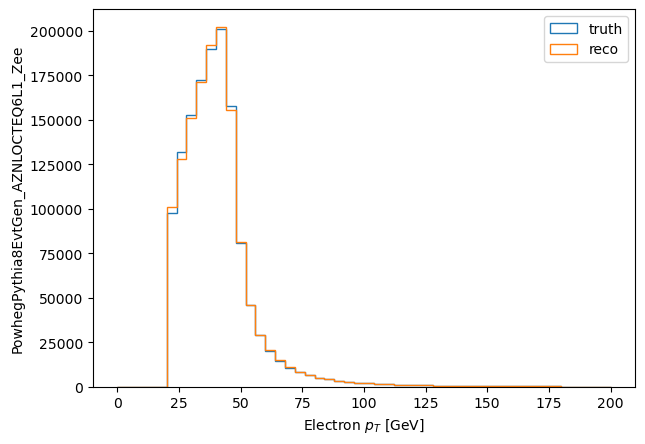

In [10]:
plt.hist((pt_matched_mc).flatten(), label='truth', bins=50, range=(0,200), histtype='step')
plt.hist((pt_matched_reco).flatten(), label='reco', bins=50, range=(0,200), histtype='step')
plt.legend()
plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')
_ = plt.xlabel('Electron $p_T$ [GeV]')

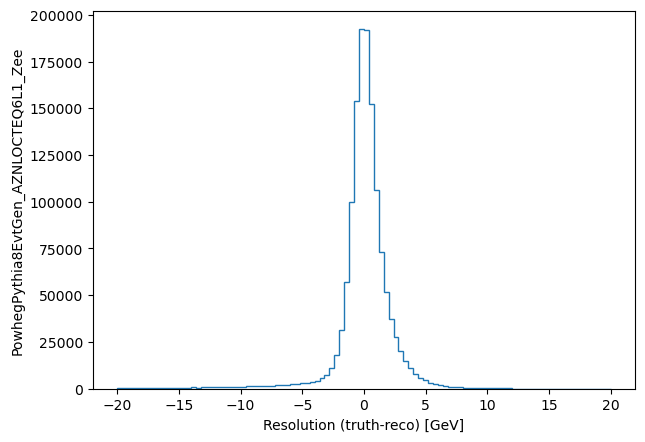

In [11]:
plt.hist((pt_matched_mc-pt_matched_reco).flatten(), bins=100, range=(-20, 20), histtype='step')
plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')
_ = plt.xlabel("Resolution (truth-reco) [GeV]")

Finally, lets look at the number of particles close by

In [12]:
match_count = make_local(good_eles.all.Count())

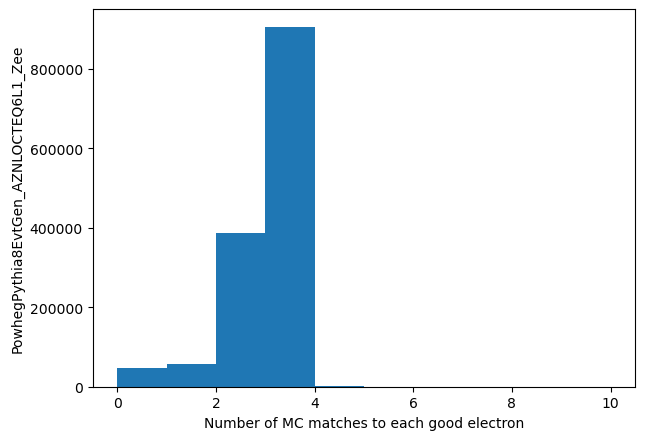

In [13]:
plt.hist(match_count.flatten(), bins=10, range=(0,10))
plt.xlabel('Number of MC matches to each good electron')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

I'm not at all sure what the 2's and 3's are due to - I'm assuming brems or similar objects. This is to investigate at a later time!

I would note that the function `associate_particles` didn't just write itself. I had to think a bit carefully. I had first attempted to write it the definition of the column `all` in a single line. However, it gets very hard to track how many levels deep you are in an array.